# Variational Autoencoder with MNIST

We will use the MNIST dataset of handwritten digits [http://yann.lecun.com/exdb/mnist/] again, to train a variational autoencoder with will also be able to generate new digits.

As a source for this notebook, see [https://blog.keras.io/building-autoencoders-in-keras.html] . However, the generation of numbers in this example does not actually do anything VAE specific. A more accurate example can be found here: [https://towardsdatascience.com/teaching-a-variational-autoencoder-vae-to-draw-mnist-characters-978675c95776] .

To begin, we need to load some python modules including common layers from keras.

In [ ]:
# MNIST dataset
from keras.datasets import mnist

# numpy and pyplot
import numpy as np
import matplotlib.pyplot as plt

# keras
import keras
from keras.layers import Input, Dense, Flatten, Reshape, Conv2D, MaxPooling2D, UpSampling2D, Dropout, BatchNormalization
from keras.layers import Multiply, Add, GaussianNoise, Lambda
from keras.models import Model
from keras.losses import binary_crossentropy
import keras.backend as K

We prepare the data by normalizing it.

Sincle we are doing unsupervised learning here, we will not need the labels provided by the dataset for now. We keep them however, as they will help with visualizing the results later.

There are 60k training and 10k test examples.

In [ ]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
print(x_train.shape)
print(x_test.shape)

In priciple, an autoencoder consists of two models: the encoder and the decoder. To represent this, we are using keras' functional API where we can easily define models from component models.

We start by defining the encoder, whose output will no be the latent vector, but the mean and log of the standard deviation of the latent representations.

The next submodel is on that sample from the distribution generated by the encoder.

Then we define the decoder, which takes the sampled latent vector as input and produces full-size images again.

Finally, we concatenate everything to get our variational autoencoder.

In [ ]:
def makeVAE(encodingDim=32):
    # this is our input placeholder
    inputImg = Input(shape=x_train.shape[1:])
    x = Reshape((*inputImg.shape.as_list()[1:],1))(inputImg)
    # encoder
    x = Conv2D(16, kernel_size=(5,5), activation='relu', padding="same")(x)
    x = Conv2D(32, kernel_size=(3,3), activation='relu', padding="same")(x)
    x = MaxPooling2D(pool_size=(2,2))(x)
    x = BatchNormalization()(x)
    x = Conv2D(64, kernel_size=(3,3), activation='relu', padding="same")(x)
    x = Conv2D(32, kernel_size=(1,1), activation='relu', padding="same")(x)
    x = Conv2D(64, kernel_size=(3,3), activation='relu', padding="same")(x)
    x = MaxPooling2D(pool_size=(2,2))(x)
    x = BatchNormalization()(x)
    x = Conv2D(128, kernel_size=(3,3), activation='relu', padding="same")(x)
    x = Conv2D(64, kernel_size=(1,1), activation='relu', padding="same")(x)
    x = Conv2D(128, kernel_size=(3,3), activation='relu', padding="same")(x)
    x = Conv2D(64, kernel_size=(1,1), activation='relu', padding="same")(x)
    x = Conv2D(64, kernel_size=(3,3), activation='relu', padding="same")(x)
    x = BatchNormalization()(x)
    x = Conv2D(32, kernel_size=(1,1), activation='relu', padding="same")(x)
    lastConvShape = x.shape.as_list()[1:]
    
    x = Flatten()(x)    
    x = Dense(encodingDim*4, activation='relu')(x)
    x = Dense(encodingDim*2, activation='relu')(x)
    x = Dense(encodingDim, activation='relu')(x)
    
    mean = Dense(encodingDim)(x)
    logstdev = Dense(encodingDim)(x)
    
    encoder = Model(inputImg, [mean, logstdev], name="encoder")
    encoder.summary()

    def sampling(args):
        mean, logstdev = args
        eps = K.random_normal(shape=(K.shape(logstdev)[0], encodingDim))
        return mean + K.exp(logstdev) * eps

    meanS = Input(shape=(encodingDim,))
    logstdevS = Input(shape=(encodingDim,))
    x = Lambda(sampling)([meanS, logstdevS])
    sample = Model([meanS, logstdevS], x, name="sample")
    sample.summary()
    
    # this is our latent space placeholder
    inputLat = Input(shape=(encodingDim,))
    #decoder
    x = Dense(encodingDim*4, activation='relu')(inputLat)
    x = Dense(np.prod(lastConvShape), activation='relu')(x)
    
    x = Reshape(lastConvShape)(x) # remove channel dimension
    x = Conv2D(64, kernel_size=(3,3), activation='relu', padding="same")(x)
    x = BatchNormalization()(x)
    x = Conv2D(64, kernel_size=(1,1), activation='relu', padding="same")(x)
    x = Conv2D(128, kernel_size=(3,3), activation='relu', padding="same")(x)
    x = Conv2D(64, kernel_size=(1,1), activation='relu', padding="same")(x)
    x = Conv2D(128, kernel_size=(3,3), activation='relu', padding="same")(x)
    x = UpSampling2D(size=(2,2))(x)
    x = BatchNormalization()(x)
    x = Conv2D(64, kernel_size=(3,3), activation='relu', padding="same")(x)
    x = Conv2D(32, kernel_size=(1,1), activation='relu', padding="same")(x)
    x = Conv2D(64, kernel_size=(3,3), activation='relu', padding="same")(x)
    x = UpSampling2D(size=(2,2))(x)
    x = BatchNormalization()(x)
    x = Conv2D(32, kernel_size=(3,3), activation='relu', padding="same")(x)
    x = BatchNormalization()(x)
    x = Conv2D(1, kernel_size=(5,5), activation='sigmoid', padding="same")(x)
    x = Reshape(x.shape.as_list()[1:3])(x) # remove channel dimension

    
    decoder = Model(inputLat, x, name="decoder")
    decoder.summary()

    # this model maps an input to its reconstruction
    autoencoder = Model(inputImg, decoder(sample(encoder(inputImg))), name="vae")
    autoencoder.summary()
    
    def loss(x, output):
        recon_loss = K.sum(binary_crossentropy(x, output))
        """
        This is quite dirty: using the layer handles from the definition of the encoder to calculate the loss.
        It would be better to have these values as additional outputs of the network,
        but keras does not allow passing multiple outputs into a single loss function.
        """
        kl_loss = - 0.5 * K.mean(1. + 2.*logstdev - K.square(mean) - K.exp(2.*logstdev), axis=-1)
        return recon_loss + kl_loss
        #return kl_loss
    
    return encoder, decoder, autoencoder, sample, loss

In [ ]:
encoder, decoder, autoencoder, sample, loss = makeVAE(16)
opt = keras.optimizers.Adam(lr=0.001)
autoencoder.compile(optimizer=opt, loss=loss)

Here we passed our custom loss function when compiling the model. Next, we will fit.

In [ ]:
autoencoder.fit(x_train, x_train,
                epochs=40,
                batch_size=256,
                shuffle=True,
                validation_data=(x_test, x_test))

Here we define a function to compare original and reconstructed images, which we will use later.

In [48]:
def showImages(ae, data):
    decoded_imgs = ae.predict(data)

    n = data.shape[0]  # how many digits we will display
    height = 20
    plt.figure(figsize=(height, height/n*2))
    for i in range(n):
        # display original
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(data[i])
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        # display reconstruction
        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(decoded_imgs[i])
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()

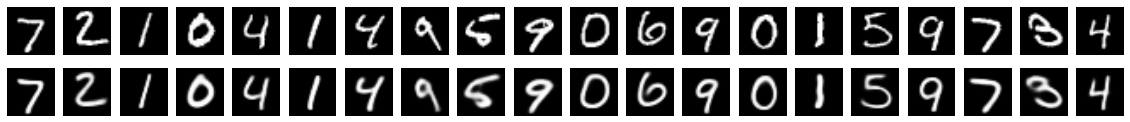

In [49]:
showImages(autoencoder, x_test[0:20])

We can also sample the latent vectors, which should follow a unit gaussian to generate new digits.

In [52]:
def showImagesGen(decoder, sample=sample, n=20):
    latentDim = sample.inputs[0].shape.as_list()[-1]
    mean = np.array([0.]*latentDim*n).reshape([n,latentDim])
    stdev = np.array([1.]*latentDim*n).reshape([n,latentDim])
    decoded_imgs = decoder.predict(sample.predict([mean, stdev]))

    height = 20
    plt.figure(figsize=(height, height/n))
    for i in range(n):
        # display reconstruction
        ax = plt.subplot(1, n, i + 1)
        plt.imshow(decoded_imgs[i])
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()

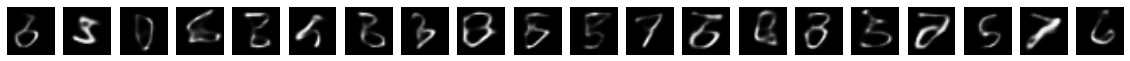

In [53]:
showImagesGen(decoder)